# STA Field Variability Analysis - 2018-05-31

In [8]:
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
from imaka.analysis import plot_stats
import random
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from imaka.analysis import moffat
from astropy.table import Table
from astropy.modeling import fitting
from astropy.stats import sigma_clip
import scipy.linalg
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

stack_dir = "//g/lu/data/imaka/onaga/20180531/sta/reduce/stacks/"
stack1 = stack_dir + "FLD2_stack_threeWFSLS_B2_c.fits"
stack2 = stack_dir + "FLD2_stack_threeWFSMean_B2_c.fits"
stack3 = stack_dir + "FLD2_stack_threeWFS_LS_c.fits"
stars1 = stack_dir + "FLD2_stack_threeWFSLS_B2_c_stars.txt"
stars2 = stack_dir + "FLD2_stack_threeWFSMean_B2_c_stars.txt"
stars3 = stack_dir + "FLD2_stack_threeWFS_LS_c_stars.txt"
stacks = [stack1, stack2, stack3]
stars  = [stars1, stars2, stars3]

Max:  0.43458894635948453
Min:  0.30597308297255627
Range:  0.12861586338692826


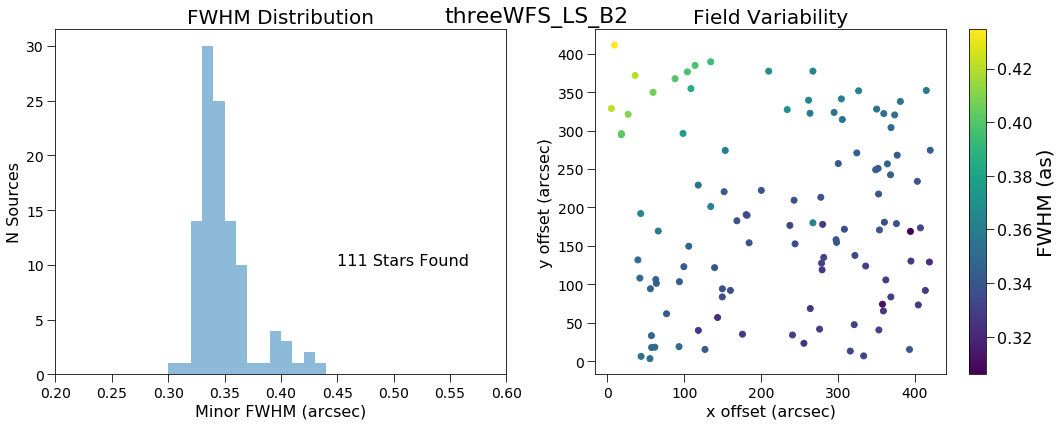

In [57]:
plot_var(stack1, stars1, "threeWFS_LS_B2")


Max:  0.4326367586697694
Min:  0.308994341825747
Range:  0.12364241684402244


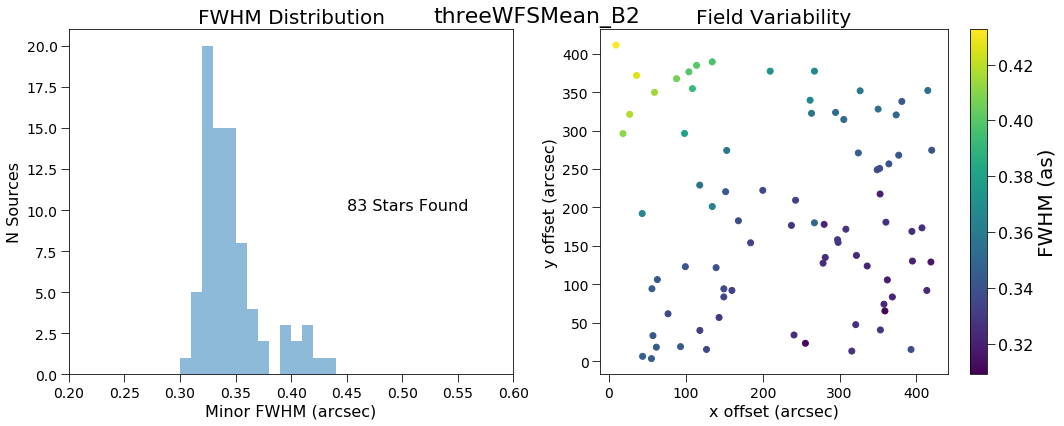

In [58]:
plot_var(stack2, stars2, "threeWFSMean_B2")

Max:  0.40904428522749814
Min:  0.3116979161715392
Range:  0.09734636905595895


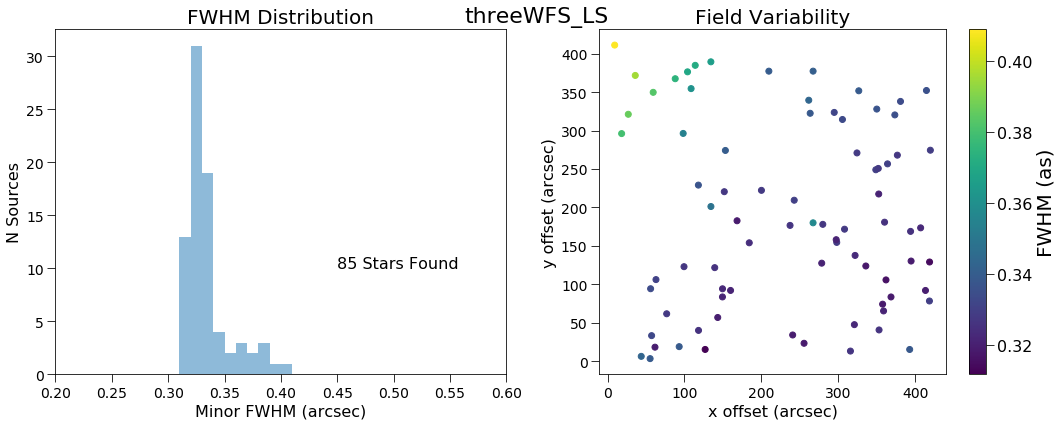

In [59]:
plot_var(stack3, stars3, "threeWFS_LS")

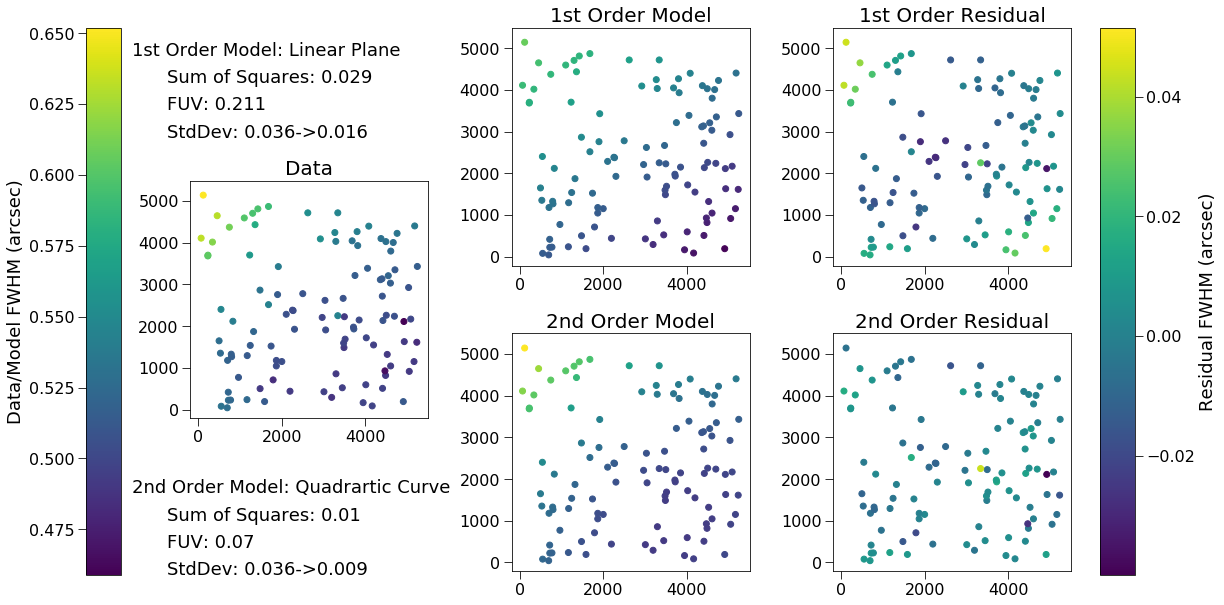

In [661]:
#x, y, FWHM = get_var_dat(stack1, stars1)
#x, y, beta = get_var_dat(stack1, stars1, metric='beta')
#x, y, alpha = get_var_dat(stack1, stars1, metric='alpha')
#plot_var(x, y, FWHM, title='Stack 1')
z1_fwhm_min, z2_fwhm_min = modcomp(x_cent, y_cent, FWHM_min, metric='FWHM')
#fwhm1, fwhm2 = modcomp(x_cent, y_cent, beta, metric='beta')
#fwhm1, fwhm2 = modcomp(x_cent, y_cent, alpha_min, metric='alpha')


In [433]:
def modcomp(x, y, FWHM, metric='FWHM'):

    z1, X, Y, Z1 = fit_plane(x, y, FWHM, order=1)
    z2, X, Y, Z2 = fit_plane(x, y, FWHM, order=2)

    #Calculate Residuals
    res_dat1 = FWHM-z1
    res_dat2 = FWHM-z2

    SS1 = np.sum(res_dat1**2)
    SS2 = np.sum(res_dat2**2)

    FUV1 = np.sum(res_dat1**2) / np.sum((FWHM-np.mean(FWHM))**2)
    FUV2 = np.sum(res_dat2**2) / np.sum((FWHM-np.mean(FWHM))**2)

    std0 = np.std(FWHM)
    std1 = np.std(res_dat1)
    std2 = np.std(res_dat2)

    #Define plot ranges
    datmin = np.min(FWHM)
    datmax = np.max(FWHM)
    resmin = np.min(np.concatenate([res_dat1, res_dat2]))
    resmax = np.max(np.concatenate([res_dat1, res_dat2]))

    #Plot
    #axes = [dat, mod1, mod2, res1, res2]
    #fig, axes = plt.subplots(figsize=(16,10))
    fig, _ = plt.subplots(figsize=(16,10))

    dat = plt.subplot2grid((4,6), (1, 0), colspan=2, rowspan=2)
    mod1 = plt.subplot2grid((4, 6), (0, 2), colspan=2, rowspan=2)
    mod2 = plt.subplot2grid((4, 6), (2, 2), colspan=2, rowspan=2)
    res1 = plt.subplot2grid((4, 6), (0, 4), colspan=2, rowspan=2)
    res2 = plt.subplot2grid((4, 6), (2, 4), colspan=2, rowspan=2)

    sc_dat = dat.scatter(x, y, c=FWHM, vmin=datmin, vmax=datmax)
    dat.set_title("Data")
    dat.axis("square")

    mod1.scatter(x, y, c=z1, vmin=datmin, vmax=datmax)
    mod1.set_title('1st Order Model')
    mod1.axis("square")

    mod2.scatter(x, y, c=z2, vmin=datmin, vmax=datmax)
    mod2.set_title('2nd Order Model')
    mod2.axis("square")

    sc_res = res1.scatter(x, y, c=res_dat1, vmin=resmin, vmax=resmax)
    res1.set_title('1st Order Residual')
    res1.axis("square")

    res2.scatter(x, y, c=res_dat2, vmin=resmin, vmax=resmax)
    res2.set_title('2nd Order Residual')
    res2.axis("square")

    cbaxes1 = fig.add_axes([0.04, 0.12, 0.03, 0.76])
    cbar1 = plt.colorbar(sc_dat, cax=cbaxes1, ticklocation = 'left')
    if metric=='FWHM':
        cbar1.set_label('Data/Model FWHM (arcsec)', fontsize=18)
    elif metric=='beta':
        cbar1.set_label('Data/Model Beta', fontsize=18)
    elif metric=='alpha':
        cbar1.set_label('Data/Model Alpha (arcsec)', fontsize=18)

    cbaxes2 = fig.add_axes([0.92, 0.12, 0.03, 0.76])
    cbar2 = plt.colorbar(sc_res, cax=cbaxes2, ticklocation = 'right')
    if metric=='FWHM':
        cbar2.set_label('Residual FWHM (arcsec)', fontsize=18)
    elif metric=='beta':
        cbar2.set_label('Residual Beta', fontsize=18)
    elif metric=='alpha':
        cbar2.set_label('Residual Alpha (arcsec)', fontsize=18)

    plt.subplots_adjust(hspace=0.8, wspace=0.8)

    plt.text(-28, 0.95, '1st Order Model: Linear Plane', fontsize=18)
    plt.text(-27, 0.9, 'Sum of Squares: '+str(np.round(SS1,3)), fontsize=18)
    plt.text(-27, 0.85, 'FUV: '+str(np.round(FUV1,3)), fontsize=18)
    plt.text(-27, 0.8, 'StdDev: '+str(np.round(std0,3))+'->'+str(np.round(std1,3)), fontsize=18)


    plt.text(-28, 0.15, '2nd Order Model: Quadrartic Curve', fontsize=18)
    plt.text(-27, 0.1, 'Sum of Squares: '+str(np.round(SS2,3)), fontsize=18)
    plt.text(-27, 0.05, 'FUV: '+str(np.round(FUV2,3)), fontsize=18)
    plt.text(-27, 0.0, 'StdDev: '+str(np.round(std0,3))+'->'+str(np.round(std2,3)), fontsize=18)
    
    return z1, z2


def get_var_dat(img_file, starlist, metric='FWHM'):
    
    # Read in stack and starlist
    img, hdr = fits.getdata(img_file, header=True)
    stars = Table.read(starlist, format='ascii')
    N_stars = len(stars)

    x_cents = []
    y_cents = []
    mags  = []
    FWHMs   = []
    betas = []
    alphas = []

    # Pick out stars within above a flux, below a saturation limit, and not on edges
    stars[0]
    for star in stars:
        if star['flux'] > 0 and star['peak'] < 20000 and \
        star['ycentroid']-10 > 0 and star['xcentroid']-10 > 0 and \
        star['ycentroid']+10<np.shape(img)[0] and star['xcentroid']+10<np.shape(img)[1]:
            x_cents.append(star['xcentroid'])
            y_cents.append(star['ycentroid'])
            mags.append(-2.5 * np.log10(star['flux']))

    # Moffat fit to all sources in above cut        
    for i in range(len(x_cents)):
        one_star = img[int(y_cents[i])-10 : int(y_cents[i])+10+1, int(x_cents[i])-10 : int(x_cents[i])+10+1]
        y, x = np.mgrid[:21, :21]
        z = one_star
        m_init = moffat.Elliptical_Moffat2D(N_sky = 0, amplitude=np.amax(z),  x_0=10.5, y_0=10.5, width_x = 4.55, width_y=4.17)
        fit_m = fitting.LevMarLSQFitter()
        m = fit_m(m_init, x, y, z)
        if m.width_x.value > 0 and m.width_y.value > 0: 
            if abs(m.width_x.value) < abs(m.width_y.value):
                FWHM = 2*abs(m.width_x.value)*np.sqrt((2**(1/m.power.value))-1)*0.08
                alpha = m.width_x.value
            else:
                FWHM = 2*abs(m.width_y.value)*np.sqrt((2**(1/m.power.value))-1)*0.08
                alpha = m.width_y.value
            beta = m.power.value

            FWHMs.append(FWHM)
            betas.append(beta)
            alphas.append(alpha)

    FWHMs = np.array(FWHMs)
    ind = np.where(FWHMs>0.3)
    
    FWHMs = FWHMs[ind]
    betas = np.array(betas)[ind]
    alphas = np.array(alphas)[ind]
    x_cents = np.array(x_cents)[ind]
    y_cents = np.array(y_cents)[ind]
    
        
    #Sigma clip data (not currently used)
#     filt = sigma_clip(FWHMs, sigma=3, iters=5, copy=False)
#     x = np.ma.array(FWHMs, mask=filt.mask)
#     FWHMs_clip = x[~x.mask].data
#     x = np.ma.array(x_cents, mask=filt.mask)
#     xcents_clip = x[~x.mask].data
#     x = np.ma.array(y_cents, mask=filt.mask)
#     ycents_clip = x[~x.mask].data
    
    if metric=='FWHM':
        return x_cents, y_cents, FWHMs
    elif metric=='beta':
        return x_cents, y_cents, betas
    elif metric=='alpha':
        return x_cents, y_cents, alphas


def fit_plane(x, y, FWHM, order=1):

    # some 3-dim points
    data = np.array([x, y, FWHM]).transpose()

    # regular grid covering the domain of the data
    X,Y = np.meshgrid(np.arange(0, 5280, 10), np.arange(0,5280, 10))
    XX = X.flatten()
    YY = Y.flatten()

    #order = 2    # 1: linear, 2: quadratic
    if order == 1:
        # best-fit linear plane
        A = np.c_[data[:,0], data[:,1], np.ones(data.shape[0])]
        C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])    # coefficients

        # evaluate it on grid
        Z = C[0]*X + C[1]*Y + C[2]
        z = C[0]*x + C[1]*y + C[2]
    
    elif order == 2:
        # best-fit quadratic curve
        A = np.c_[np.ones(data.shape[0]), data[:,:2], np.prod(data[:,:2], axis=1), data[:,:2]**2]
        C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])

        # evaluate it on a grid
        Z = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX*YY, XX**2, YY**2], C).reshape(X.shape)
        z = np.dot(np.c_[np.ones(x.shape), x, y, x*y, x**2, y**2], C).reshape(x.shape)

        
    # plot points and fitted surface
    #fig = plt.figure()
    #ax = fig.gca(projection='3d')
    #ax.scatter(data[:,0], data[:,1], data[:,2], c='r', alpha=0.5, s=10)
    #ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.5, color='b')
    ##plt.xlabel('X')
    #plt.ylabel('Y')
    #ax.set_zlabel('Z')
    #ax.axis('equal')
    #ax.axis('tight')
    #plt.show()

    FWHM_plane = Z
    
    return z, X, Y, Z, C

def plot_var(x_cents, y_cents, FWHMs, title=None):

    plt.figure(1, figsize=(10,4))

    plt.subplot(121)
    bins = np.arange(0,1, .01)
    plt.hist(FWHMs, bins=bins, alpha=0.5)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)
    plt.xlabel('Minor FWHM (arcsec)', fontsize=16)
    plt.ylabel('N Sources', fontsize=16)
    plt.title('FWHM Distribution', fontsize=20)
    plt.xlim(0.2, 0.6)
    plt.text(0.45, 10, str(len(FWHMs))+" Stars Found", fontsize=16)
    plt.legend()

    plt.subplot(122)
    #plt.scatter(np.array(xcents_clip)*0.08, np.array(ycents_clip)*0.08, c=np.array(FWHMs_clip))#, alpha=0.75)#, vmin=np.mean(FWHMs)-np.std(FWHMs), vmax=np.mean(FWHMs)+np.std(FWHMs))
    plt.scatter(np.array(x_cents)*0.08, np.array(y_cents)*0.08, c=np.array(FWHMs))#, alpha=0.75)#, vmin=np.mean(FWHMs)-np.std(FWHMs), vmax=np.mean(FWHMs)+np.std(FWHMs))
    plt.xlabel('x offset (arcsec)', fontsize=16) 
    plt.ylabel('y offset (arcsec)', fontsize=16)
    plt.title("Field Variability", fontsize=20)
    plt.colorbar(label='FWHM (as)')
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)
    plt.gca().set_aspect('equal', adjustable='box')
    
    if title!=None:
        plt.suptitle(title, fontsize=22)

    plt.tight_layout()
    
    return

def sig_clip(x_cents, y_cents, dat):
    
    filt = sigma_clip(dat, sigma=3, iters=5, copy=False)
    x = np.ma.array(dat, mask=filt.mask)
    dat_clip = x[~x.mask].data
    x = np.ma.array(x_cents, mask=filt.mask)
    x_clip = x[~x.mask].data
    x = np.ma.array(y_cents, mask=filt.mask)
    y_clip = x[~x.mask].data
    
    return x_clip, y_clip, dat_clip

def sig_clip_mod(x_cents, y_cents, dat, mod, res):
    
    filt = sigma_clip(res, sigma=3, iters=5, copy=False)
    x = np.ma.array(res, mask=filt.mask)
    res_clip = x[~x.mask].data
    x = np.ma.array(x_cents, mask=filt.mask)
    x_clip = x[~x.mask].data
    x = np.ma.array(y_cents, mask=filt.mask)
    y_clip = x[~x.mask].data
    x = np.ma.array(dat, mask=filt.mask)
    dat_clip = x[~x.mask].data
    x = np.ma.array(mod, mask=filt.mask)
    mod_clip = x[~x.mask].data
    
    return x_clip, y_clip, dat_clip, mod_clip, res_clip

def fit_bootstrap(x, y, FWHM):
    """
    Full sample bootstrap w/replacement of 3d quadrtic curve model fitting to STA field variation
    """
    #Iterate over 100 samples
    pars_boot = []
    for i in range(100):

        # Make one sample
        x_samp = []
        y_samp = []
        FWHM_samp = []
        for i in range(len(x)):
            ind = random.randint(1,len(x)-1)
            x_samp.append(x[ind])
            y_samp.append(y[ind])
            FWHM_samp.append(FWHM[ind])

        # Fit sample and add it to data
        z, X, Y, Z, pars = fit_plane(np.array(x_samp), np.array(y_samp), np.array(FWHM_samp), order=2)
        pars_boot.append(pars)

    # combine data
    pars_boot = np.array(pars_boot)
    pars_means = np.mean(pars_boot, axis=0)
    pars_errs = np.std(pars_boot, axis=0)

    return pars_means, pars_errs

In [713]:
img_file = stack1
starlist = stars1

def write_mof_list(img_file, starlist):
    """
    FWHM and alpha (moffat width parameter) in arcseconds, for STA camera plate scale (0.12"/pix)
    """

    # Read in stack and starlist
    img, hdr = fits.getdata(img_file, header=True)
    stars = Table.read(starlist, format='ascii')
    ps = 0.12 #FOR STA CAMERA

    # Filter for positive flux, non saturated sources, and trim edges
    good = np.where((stars['flux'] > 0) & (stars['peak'] < 20000) & \
        (stars['ycentroid']-10 > 0) & (stars['xcentroid']-10 > 0) & \
        (stars['ycentroid']+10<np.shape(img)[0]) & (stars['xcentroid']+10<np.shape(img)[1]))

    # Create arrays for stats table columnds
    Nstars = len(stars[good])
    x_cent = np.array(stars[good]['xcentroid'])
    y_cent = np.array(stars[good]['ycentroid'])

    N_sky     = []
    amplitude = []
    phi       = []
    beta      = []
    alpha_min = []
    alpha_maj = []
    FWHM_min  = []
    FWHM_maj  = []

    for ii in range(Nstars):

        # Cut out one star and define data for fit
        one_star = img[int(y_cent[ii])-10 : int(y_cent[ii])+10+1, int(x_cent[ii])-10 : int(x_cent[ii])+10+1]
        y, x = np.mgrid[:21, :21]
        z = one_star

        # Fit data to moffat profile
        m_init = moffat.Elliptical_Moffat2D(N_sky = 0, amplitude=np.amax(z),  x_0=10.5, y_0=10.5, width_x = 4.55, width_y=4.17)
        fit_m = fitting.LevMarLSQFitter()
        m = fit_m(m_init, x, y, z)

        # Filter
        if m.power.value > 0 and m.power.value < 20:

            amplitude.append(m.amplitude.value)
            N_sky.append(m.N_sky.value)
            beta.append(m.power.value)

            ax = np.abs(m.width_x.value) * ps
            ay = np.abs(m.width_y.value) * ps

            if ax < ay:
                alpha_min.append(ax) 
                alpha_maj.append(ay)
                FWHM_min.append(2*abs(ax)*np.sqrt((2**(1/m.power.value))-1))
                FWHM_maj.append(2*abs(ay)*np.sqrt((2**(1/m.power.value))-1))
                phi.append(m.phi.value)
            elif ax > ay:
                alpha_min.append(ay)
                alpha_maj.append(ax)
                FWHM_min.append(2*abs(ay)*np.sqrt((2**(1/m.power.value))-1))
                FWHM_maj.append(2*abs(ax)*np.sqrt((2**(1/m.power.value))-1))
                phi.append(m.phi.value-(np.pi/2))


    for jj in range(len(phi)):
        num = phi[jj]
        while num > np.pi:
            num -= np.pi
        while num < 0:
            num += np.pi
        phi[jj] = num        

    N_sky = np.array(N_sky)
    amplitude = np.array(amplitude)
    phi = np.array(phi)
    beta = np.array(beta)
    alpha_min = np.array(alpha_min)
    alpha_maj = np.array(alpha_maj)
    FWHM_min = np.array(FWHM_min)
    FWHM_maj = np.array(FWHM_maj)

    return x_cent, y_cent, FWHM_min, FWHM_maj, alpha_min, alpha_maj, beta, phi, amplitude, N_sky

Text(-27,0,'StdDev: 0.056->0.007')

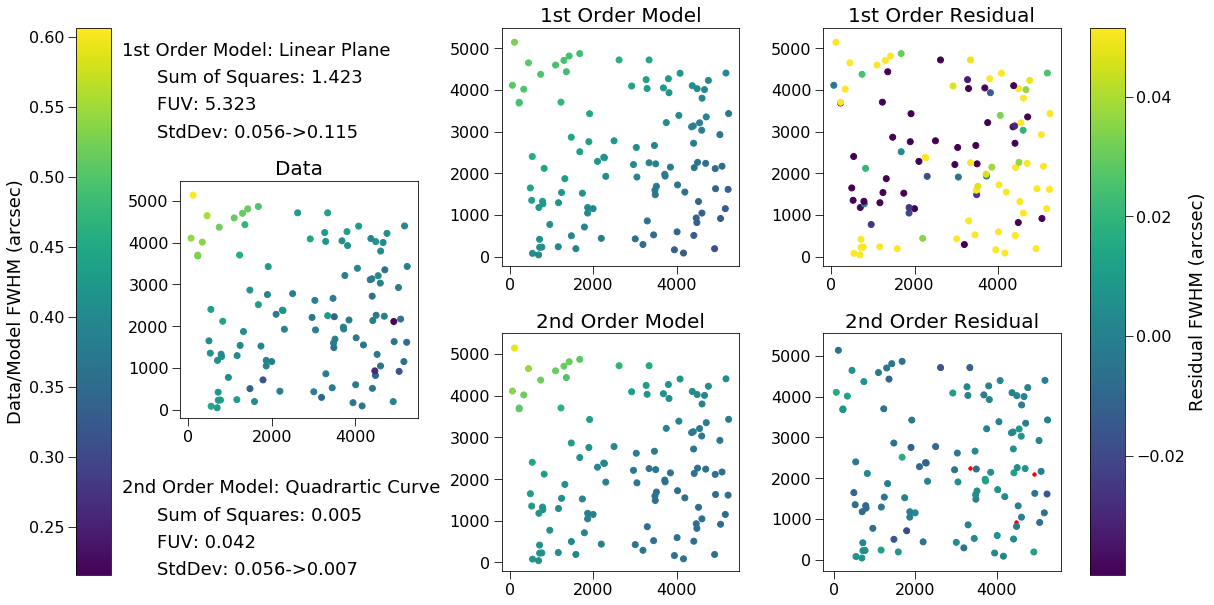

In [779]:
x_cent, y_cent, FWHM_min, FWHM_maj, alpha_min, alpha_maj, beta, phi, amplitude, N_sky = write_mof_list(stack1, stars1)

data = alpha_min

z1_fwhm_min, X, Y, Z = fit_plane(x_cent, y_cent, data, order=1)
z2_fwhm_min, X, Y, Z = fit_plane(x_cent, y_cent, data, order=2)


res_dat1_a = data-z1_fwhm_min
res_dat2_a = data-z2_fwhm_min

xc1, yc1, dc1, mc1, rc1 = sig_clip(x_cent, y_cent, data, z1, res_dat1_b)
xc2a, yc2a, dc2a, mc2a, rc2a = sig_clip(x_cent, y_cent, data, z2, res_dat2_a)

datmin = np.min(data)
datmax = np.max(data)
resmin = np.min(np.concatenate([res_dat1, res_dat2]))
resmax = np.max(np.concatenate([res_dat1, res_dat2]))

fig, _ = plt.subplots(figsize=(16,10))

dat = plt.subplot2grid((4,6), (1, 0), colspan=2, rowspan=2)
mod1 = plt.subplot2grid((4, 6), (0, 2), colspan=2, rowspan=2)
mod2 = plt.subplot2grid((4, 6), (2, 2), colspan=2, rowspan=2)
res1 = plt.subplot2grid((4, 6), (0, 4), colspan=2, rowspan=2)
res2 = plt.subplot2grid((4, 6), (2, 4), colspan=2, rowspan=2)

sc_dat = dat.scatter(x_cent, y_cent, c=data, vmin=datmin, vmax=datmax)
dat.set_title("Data")
dat.axis("square")

mod1.scatter(x_cent, y_cent, c=z1_fwhm_min, vmin=datmin, vmax=datmax)
mod1.set_title('1st Order Model')
mod1.axis("square")

mod2.scatter(x_cent, y_cent, c=z2_fwhm_min, vmin=datmin, vmax=datmax)
mod2.set_title('2nd Order Model')
mod2.axis("square")

res2.plot(x_cent, y_cent, 'r.', zorder=1)
sc_res = res1.scatter(xc1, yc1, c=rc1, vmin=resmin, vmax=resmax, zorder=2)
res1.set_title('1st Order Residual')
res1.axis("square")

res2.plot(x_cent, y_cent, 'r.', zorder=1)
res2.scatter(xc2, yc2, c=rc2, vmin=resmin, vmax=resmax, zorder=2)
res2.set_title('2nd Order Residual')
res2.axis("square")

cbaxes1 = fig.add_axes([0.04, 0.12, 0.03, 0.76])
cbar1 = plt.colorbar(sc_dat, cax=cbaxes1, ticklocation = 'left')
cbar1.set_label('Data/Model FWHM (arcsec)', fontsize=18)

cbaxes2 = fig.add_axes([0.92, 0.12, 0.03, 0.76])
cbar2 = plt.colorbar(sc_res, cax=cbaxes2, ticklocation = 'right')
cbar2.set_label('Residual FWHM (arcsec)', fontsize=18)

plt.subplots_adjust(hspace=0.8, wspace=0.8)

N0 = len(data)
N1 = len(rc1)
N2 = len(rc2)

SS1 = np.sum(rc1**2)
SS2 = np.sum(rc2**2)

FUV1 = np.sum(rc1**2) / np.sum((dc1-np.mean(dc1))**2)
FUV2 = np.sum(rc2**2) / np.sum((dc2-np.mean(dc2))**2)

std0 = np.std(data)
std1 = np.std(rc1)
std2 = np.std(rc2)

plt.text(-28, 0.95, '1st Order Model: Linear Plane', fontsize=18)
plt.text(-27, 0.9, 'Sum of Squares: '+str(np.round(SS1,3)), fontsize=18)
plt.text(-27, 0.85, 'FUV: '+str(np.round(FUV1,3)), fontsize=18)
plt.text(-27, 0.8, 'StdDev: '+str(np.round(std0,3))+'->'+str(np.round(std1,3)), fontsize=18)


plt.text(-28, 0.15, '2nd Order Model: Quadrartic Curve', fontsize=18)
plt.text(-27, 0.1, 'Sum of Squares: '+str(np.round(SS2,3)), fontsize=18)
plt.text(-27, 0.05, 'FUV: '+str(np.round(FUV2,3)), fontsize=18)
plt.text(-27, 0.0, 'StdDev: '+str(np.round(std0,3))+'->'+str(np.round(std2,3)), fontsize=18)


# How stable is the variability?

In [253]:
from glob import glob
from astropy.io import fits
from astropy.table import Table
import numpy as np

date = '20180531'

#Specify files
img_dir ='//g/lu/data/imaka/onaga/'+date+'/sta/reduce/FLD2/'
img_files = glob(img_dir+'*threeWFS_LS_c_scan_clean.fits')
starlists = glob(img_dir+'*threeWFS_LS_c_scan_clean_stars.txt')

stack_dir = "//g/lu/data/imaka/onaga/"+date+"/sta/reduce/stacks/"
stack = stack_dir + "FLD2_stack_threeWFS_LS_c.fits"
stars = stack_dir + "FLD2_stack_threeWFS_LS_c_stars.txt"

# Determine fit parameters on a frame by frame basis

#dat_53 = []
#err_53 = []
N_53 = []
for ii in range(len(img_files)):
    x, y, FWHM = get_var_dat(img_files[ii], starlists[ii])
    #if len(x)>1:
    #    pars, errs = fit_bootstrap(x, y, FWHM)
    #    dat_53.append(pars)
    #    err_53.append(pars)
    N_62.append(len(x)) 
#dat_53 = np.array(dat_53)
#err_53 = np.array(err_53)

#Do the same thing for a single stacked image

#x, y, FWHM = get_var_dat(stack, stars)
#dat_stack_53, err_stack_53 = fit_bootstrap(x, y, FWHM)

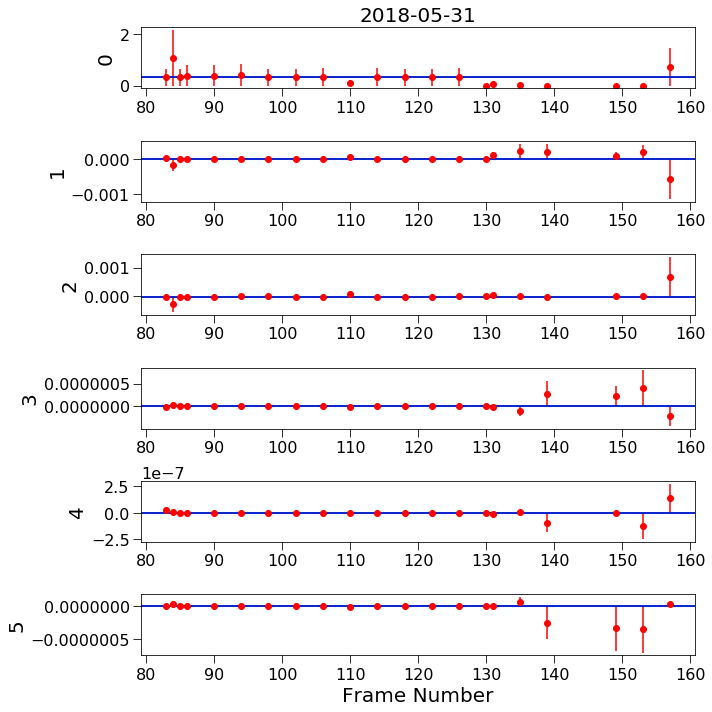

In [221]:
# Compare parameters between individual frames and stack

plt.figure(1, figsize=(10,10))
for i in range(6):
    plt.subplot(6,1,i+1)
    
    #Plot individual frame data
    plt.errorbar(frame, dat_53[:,i], yerr=err_53[:,i], fmt='ro') 
    
    # Plot stack data
    plt.axhline(dat_stack_53[i], color='g')
    #plt.axhspan(dat_stack_53[i]-err_stack_53[i], dat_stack_53[i]+err_stack_53[i], color='grey', alpha=0.5)
    plt.axhline(dat_stack_62[i], color='b')

    plt.ylabel(str(i))
    if i==5:
        plt.xlabel('Frame Number')
    if i==0:
        plt.title('2018-05-31')
plt.tight_layout()

In [400]:
N_62

[407,
 343,
 382,
 442,
 429,
 181,
 430,
 372,
 397,
 20,
 12,
 1,
 0,
 15,
 17,
 316,
 400,
 183,
 1,
 360,
 286,
 20,
 9,
 20,
 9,
 274,
 235,
 260,
 282,
 245,
 87,
 269,
 23,
 171,
 150,
 113,
 24,
 3,
 8,
 7,
 6,
 5,
 6,
 7,
 20,
 9,
 274,
 235,
 260,
 282,
 245,
 87,
 269,
 23,
 171,
 150,
 113,
 24,
 3,
 8,
 7,
 6,
 5,
 6,
 7]

In [203]:
date = '20180602'

#Specify files
img_dir ='//g/lu/data/imaka/onaga/'+date+'/sta/reduce/FLD2/'
img_files = glob(img_dir+'*threeWFS_LS_c_scan_clean.fits')
starlists = glob(img_dir+'*threeWFS_LS_c_scan_clean_stars.txt')

stack_dir = "//g/lu/data/imaka/onaga/"+date+"/sta/reduce/stacks/"
stack = stack_dir + "FLD2_stack_closed_LS.fits"
stars = stack_dir + "FLD2_stack_closed_LS_stars.txt"

#Get frame names
frame = []
for file in img_files:
    string = file.split("obj")[-1]
    string = string.split("three")[0]
    frame.append(float(string))
    
# Determine fit parameters on a frame by frame basis

dat_62 = []
err_62 = []
N_62 = []
for ii in range(len(img_files)):
    x, y, FWHM = get_var_dat(img_files[ii], starlists[ii])
    if len(x)>1:
        pars, errs = fit_bootstrap(x, y, FWHM)
        dat_62.append(pars)
        err_62.append(pars)
    else:
        dat_62.append([0, 0, 0, 0, 0, 0])
        err_62.append([0, 0, 0, 0, 0, 0])
    N_62.append(len(x)) 
dat_62 = np.array(dat_62)
err_62 = np.array(err_62)

#Do the same thing for a single stacked image

x, y, FWHM = get_var_dat(stack, stars)
dat_stack_62, err_stack_62 = fit_bootstrap(x, y, FWHM)

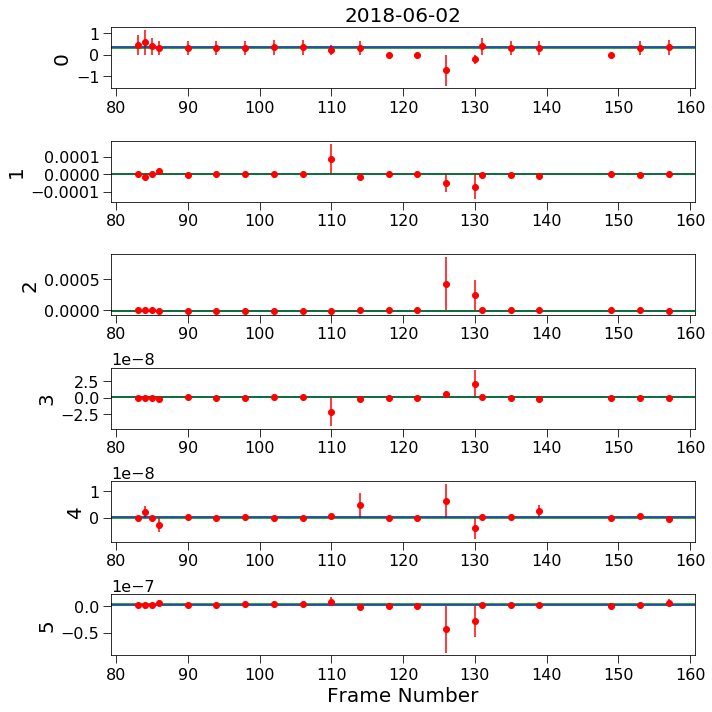

In [220]:
# Compare parameters between individual frames and stack

plt.figure(1, figsize=(10,10))
for i in range(6):
    plt.subplot(6,1,i+1)
    
    #Plot individual frame data
    plt.errorbar(frame, dat_62[:,i], yerr=err_62[:,i], fmt='ro') 
    
    # Plot stack data
    plt.axhline(dat_stack_62[i], color='b')
    #plt.axhspan(dat_stack_62[i]-err_stack_62[i], dat_stack_62[i]+err_stack_62[i], color='grey', alpha=0.5)
    plt.axhline(dat_stack_53[i], color='g')


    plt.ylabel(str(i))
    if i==5:
        plt.xlabel('Frame Number')
    if i==0:
        plt.title('2018-06-02')

plt.tight_layout()

In [224]:
C=  np.mean([dat_stack_62, dat_stack_53], axis=0)
z = np.dot(np.c_[np.ones(x.shape), x, y, x*y, x**2, y**2], C).reshape(x.shape)

array([ 3.36000992e-01, -6.43434411e-07, -1.24174687e-05,  9.10440998e-10,
       -8.49207433e-12,  3.58284303e-09])

# Test model removal on a single frame

In [346]:
img_file =  '//g/lu/data/imaka/onaga/20180531/sta/reduce/FLD2/obj061threeWFS_LS_c_scan_clean.fits'
starlist = '//g/lu/data/imaka/onaga/20180531/sta/reduce/FLD2/obj061threeWFS_LS_c_scan_clean_stars.txt'
x, y, FWHM = get_var_dat(img_file, starlist, metric='FWHM')
plane = np.dot(np.c_[np.ones(x.shape), x, y, x*y, x**2, y**2], C).reshape(x.shape)
FWHM_corr = FWHM-plane+np.min(FWHM)+0.02

In [347]:
np.min(FWHM)

0.30022251434090297

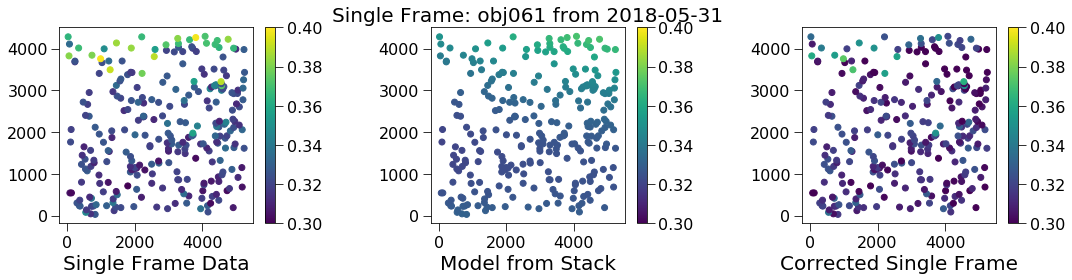

In [352]:


plt.figure(1, figsize=(15, 4))

vmin=0.30
vmax=0.4

plt.subplot(131)
plt.scatter(x, y, c=FWHM, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.xlabel('Single Frame Data')
plt.subplot(132)
plt.scatter(x, y, c=plane, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.xlabel("Model from Stack")
plt.title('Single Frame: obj061 from 2018-05-31')

plt.subplot(133)
plt.scatter(x, y, c=FWHM_corr, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.xlabel('Corrected Single Frame')
plt.tight_layout()


In [357]:
img4 = "//g/lu/data/imaka/onaga/20180601/sta/reduce/stacks/FLD2_stack_threeWFS_LS_c.fits"
str4 = "//g/lu/data/imaka/onaga/20180601/sta/reduce/stacks/FLD2_stack_threeWFS_LS_c_stars.txt"
#x4, y4, FWHM4 = get_var_dat(img4, str4, metric='FWHM')
#plane4 = np.dot(np.c_[np.ones(x4.shape), x4, y4, x4*y4, x4**2, y4**2], C).reshape(x4.shape)


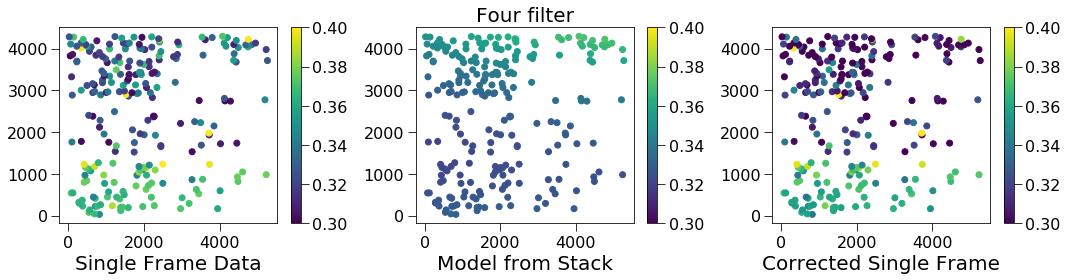

In [362]:

plt.figure(1, figsize=(15, 4))

vmin=0.30
vmax=0.4

plt.subplot(131)
plt.scatter(x4, y4, c=FWHM4, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.xlabel('Single Frame Data')
plt.subplot(132)
plt.scatter(x4, y4, c=plane4, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.xlabel("Model from Stack")
plt.title('Four filter')

plt.subplot(133)
plt.scatter(x4, y4, c=FWHM_corr4, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.xlabel('Corrected Single Frame')
plt.tight_layout()


In [395]:
FWHM_corr4 = FWHM4-plane4+np.min(FWHM4)+00.0#25 #OFFST


indA = np.where((x4<2640) & (y4<2640)) #V
indB = np.where((x4<2640) & (y4>2640)) #I
indC = np.where((x4>2640) & (y4<2640))   #B
indD = np.where((x4>2640) & (y4>2640))  #R

FWHM_A_i = np.mean(FWHM4[indA])
FWHM_B_i = np.mean(FWHM4[indB])
FWHM_C_i = np.mean(FWHM4[indC])
FWHM_D_i = np.mean(FWHM4[indD])

FWHM_A_f = np.mean(FWHM_corr4[indA])
FWHM_B_f = np.mean(FWHM_corr4[indB])
FWHM_C_f = np.mean(FWHM_corr4[indC])
FWHM_D_f = np.mean(FWHM_corr4[indD])

orig = [FWHM_A_i, FWHM_C_i, FWHM_B_i, FWHM_D_i]
corr = [FWHM_A_f, FWHM_C_f, FWHM_B_f, FWHM_D_f]

print(orig)
print(corr)

[0.35520320253908044, 0.35295597071076984, 0.33388397571939643, 0.3369672835363617]
[0.33009036255515367, 0.32627486425238056, 0.2902335486663138, 0.2778230972637513]


Text(0.5,1,'Closed Loop Change w/Correction')

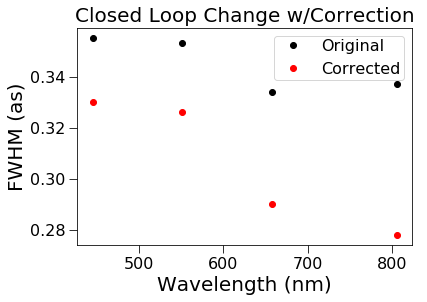

In [397]:
wvl = [445, 551, 658, 806]
plt.plot(wvl, orig, 'ko', label='Original')
plt.plot(wvl, corr, 'ro', label='Corrected')
plt.xlabel('Wavelength (nm)')
plt.ylabel('FWHM (as)')
plt.legend()
plt.title('Closed Loop Change w/Correction')

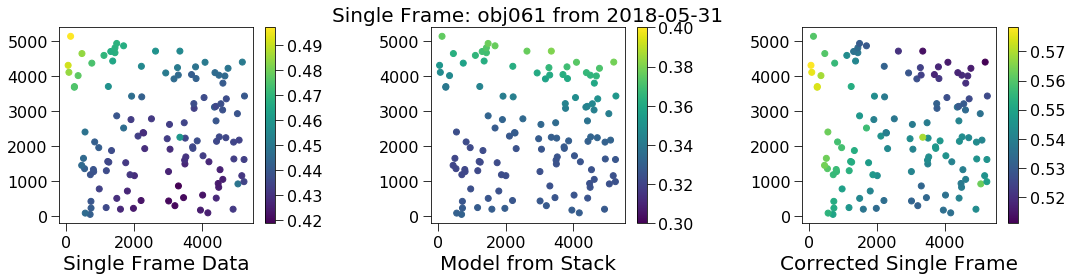

In [404]:
img_file =  '//g/lu/data/imaka/onaga/20180602/sta/reduce/stacks/FLD2_stack_open.fits'
starlist = '//g/lu/data/imaka/onaga/20180602/sta/reduce/stacks/FLD2_stack_open_stars.txt'
x, y, FWHM = get_var_dat(img_file, starlist, metric='FWHM')
plane = np.dot(np.c_[np.ones(x.shape), x, y, x*y, x**2, y**2], C).reshape(x.shape)
FWHM_corr = FWHM-plane+np.min(FWHM)+0.02

plt.figure(1, figsize=(15, 4))

vmin=0.30
vmax=0.4

plt.subplot(131)
plt.scatter(x, y, c=FWHM)#, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.xlabel('Single Frame Data')
plt.subplot(132)
plt.scatter(x, y, c=plane, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.xlabel("Model from Stack")
plt.title('Single Frame: obj061 from 2018-05-31')

plt.subplot(133)
plt.scatter(x, y, c=FWHM_corr)#, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.xlabel('Corrected Single Frame')
plt.tight_layout()


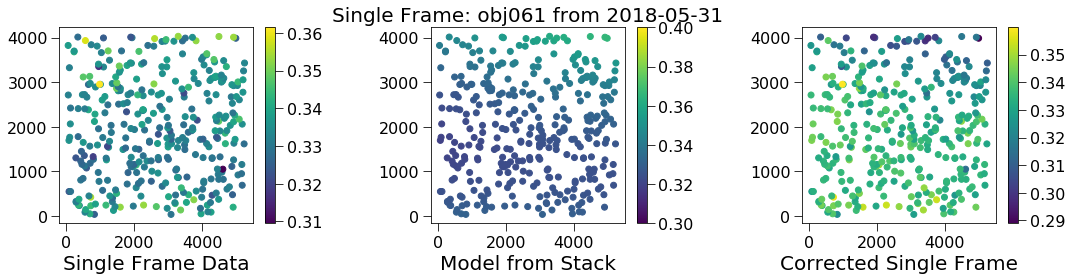

In [425]:
img_file =  '//g/lu/data/imaka/onaga/20180602/sta/reduce/stacks/FLD2_stack_closed_LS.fits'
starlist = '//g/lu/data/imaka/onaga/20180602/sta/reduce/stacks/FLD2_stack_closed_LS_stars.txt'
#x, y, FWHM = get_var_dat(img_file, starlist, metric='FWHM')
#plane = np.dot(np.c_[np.ones(x.shape), x, y, x*y, x**2, y**2], C).reshape(x.shape)
#FWHM_corr = FWHM-plane+np.min(FWHM)+0.02

plt.figure(1, figsize=(15, 4))

vmin=0.30
vmax=0.4

plt.subplot(131)
plt.scatter(x, y, c=FWHM)#, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.xlabel('Single Frame Data')
plt.subplot(132)
plt.scatter(x, y, c=plane, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.xlabel("Model from Stack")
plt.title('Single Frame: obj061 from 2018-05-31')

plt.subplot(133)
plt.scatter(x, y, c=FWHM_corr)#, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.xlabel('Corrected Single Frame')
plt.tight_layout()


In [422]:
x=x[ind]
y=y[ind]
FWHM=FWHM[ind]
plane=plane[ind]
FWHM_corr=FWHM_corr[ind]

In [421]:
ind = np.where(FWHM<0.37)

# 2018-06-01 Open Loop

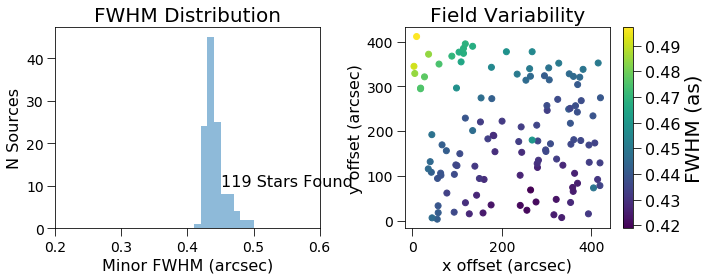

In [431]:
img_file =  '//g/lu/data/imaka/onaga/20180602/sta/reduce/stacks/FLD2_stack_open.fits'
starlist = '//g/lu/data/imaka/onaga/20180602/sta/reduce/stacks/FLD2_stack_open_stars.txt'
x, y, FWHM = get_var_dat(img_file, starlist)
plot_var(x, y, FWHM)

# 2018-06-01 Closed Loop: 3WFS_LS

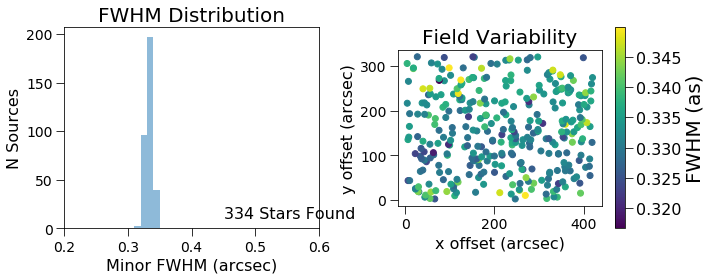

In [435]:
img_file =  '//g/lu/data/imaka/onaga/20180602/sta/reduce/stacks/FLD2_stack_closed_LS.fits'
starlist = '//g/lu/data/imaka/onaga/20180602/sta/reduce/stacks/FLD2_stack_closed_LS_stars.txt'
x, y, FWHM = get_var_dat(img_file, starlist)
x, y, FWHM=sig_clip(x, y, FWHM)
plot_var(x, y, FWHM)

In [453]:
len(x)

361

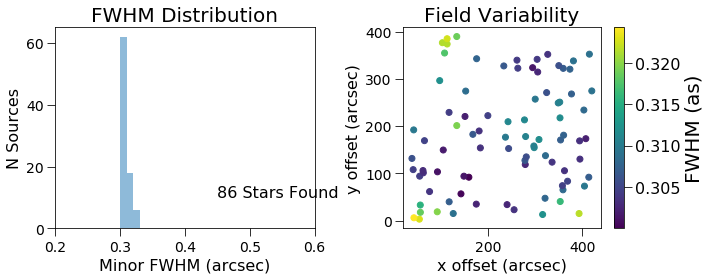

In [456]:
img_file =  '//g/lu/data/imaka/onaga/20180602/sta/reduce/stacks/FLD2_stack_closed_LS_B2.fits'
starlist = '//g/lu/data/imaka/onaga/20180602/sta/reduce/stacks/FLD2_stack_closed_LS_B2_stars.txt'
x, y, FWHM = get_var_dat(img_file, starlist, trim=True)
x, y, FWHM=sig_clip(x, y, FWHM)
plot_var(x, y, FWHM)

In [482]:
def get_var_dat(img_file, starlist, metric='FWHM', trim=False):
    
    # Read in stack and starlist
    img, hdr = fits.getdata(img_file, header=True)
    stars = Table.read(starlist, format='ascii')
    N_stars = len(stars)

    x_cents = []
    y_cents = []
    mags  = []
    FWHMs   = []
    betas = []
    alphas = []

    # Pick out stars within above a flux, below a saturation limit, and not on edges
    stars[0]
    for star in stars:
        if star['flux'] > 0 and star['peak'] < 20000 and \
        star['ycentroid']-10 > 0 and star['xcentroid']-10 > 0 and \
        star['ycentroid']+10<np.shape(img)[0] and star['xcentroid']+10<np.shape(img)[1]:
            x_cents.append(star['xcentroid'])
            y_cents.append(star['ycentroid'])
            mags.append(-2.5 * np.log10(star['flux']))
    
    #If trim=true, only use 100 (or if less than 100 stars, all) brightest stras
    if trim==True:
        mags=np.array(mags)
        if len(mags)>100:
            mags_sort = sorted(mags)
            cut = mags_sort[100]
            ind = np.where(mags<cut)
        else:
            ind  = np.where(mags>-100)    
            
        x_cents = np.array(x_cents)[ind]
        y_cents = np.array(y_cents)[ind]

    mag_final = []    
    
    # Moffat fit to all sources in above cut        
    for i in range(len(x_cents)):
        one_star = img[int(y_cents[i])-10 : int(y_cents[i])+10+1, int(x_cents[i])-10 : int(x_cents[i])+10+1]
        y, x = np.mgrid[:21, :21]
        z = one_star
        m_init = moffat.Elliptical_Moffat2D(N_sky = 0, amplitude=np.amax(z),  x_0=10.5, y_0=10.5, width_x = 4.55, width_y=4.17)
        fit_m = fitting.LevMarLSQFitter()
        m = fit_m(m_init, x, y, z)
        if m.width_x.value > 0 and m.width_y.value > 0: 
            if abs(m.width_x.value) < abs(m.width_y.value):
                FWHM = 2*abs(m.width_x.value)*np.sqrt((2**(1/m.power.value))-1)*0.08
                alpha = m.width_x.value
            else:
                FWHM = 2*abs(m.width_y.value)*np.sqrt((2**(1/m.power.value))-1)*0.08
                alpha = m.width_y.value
            beta = m.power.value

            FWHMs.append(FWHM)
            betas.append(beta)
            alphas.append(alpha)
            mag_final.append(mags[i])

    FWHMs = np.array(FWHMs)
    ind = np.where(FWHMs>0.3)
    
    FWHMs = FWHMs[ind]
    mags = np.array(mag_final)[ind]
    betas = np.array(betas)[ind]
    alphas = np.array(alphas)[ind]
    x_cents = np.array(x_cents)[ind]
    y_cents = np.array(y_cents)[ind]
    
        
    #Sigma clip data (not currently used)
#     filt = sigma_clip(FWHMs, sigma=3, iters=5, copy=False)
#     x = np.ma.array(FWHMs, mask=filt.mask)
#     FWHMs_clip = x[~x.mask].data
#     x = np.ma.array(x_cents, mask=filt.mask)
#     xcents_clip = x[~x.mask].data
#     x = np.ma.array(y_cents, mask=filt.mask)
#     ycents_clip = x[~x.mask].data
    
    if metric=='FWHM':
        return x_cents, y_cents, FWHMs, mags
    elif metric=='beta':
        return x_cents, y_cents, betas, mags
    elif metric=='alpha':
        return x_cents, y_cents, alphas, mags

In [ ]:
#look at how magnitud change sacrosss fild (opne and closed)
#loop at if magnitude is correlateed with FWHM